# Generating CNN architectures automatically with genetic algorithms

In [45]:
import random
import json
import time
import pprint

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import tensorflow as tf
from tf.keras.layers import Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tf.keras.models import Model, load_model
from tf.keras.utils import to_categorical
from tf.keras.callbacks import ModelCheckpoint

print(tf.__version__)

2.8.0


In [ ]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.style.use("ggplot")

In [46]:
def plot_classification_result(history):
    # plotting the training accuracy and loss
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'],loc='upper left')
    plt.figure(figsize = (60,20))
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'],)
    plt.plot(history.history['val_loss'],)
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.figure(figsize = (20,10))
    plt.show()

# ResNets

This project is based in ResNets, using this kind of Convolutional Neural Networks allows us to make very deep neural networks avoiding gradient vanishing and overfitting issues.

In [47]:
# Static class Layer
class Layer():
    @staticmethod
    def skip_layer_encode() -> str :
        """
        Return a randomly initialized skip layer with two convolutions

        Returns:
            str: String representing the number of filters in the two
                 convolutions
        """
        f1 = 2 ** random.randint(5, 9) # number from 32 to 512
        f2 = 2 ** random.randint(5, 9) # number from 32 to 512
        return f"{f1}_{f2}"

    @staticmethod
    def pooling_layer_encode() -> str:
        """
        Returns a pooling layer

        Returns:
            str: Mean or Max pooling layer representation
        """
        q = random.random()
        if q < 0.5:
            return "max"
        else:
            return "mean"
        
    @staticmethod
    def random_layer(skip_layer_prob=0.70) -> str:
        """
        Returns randombly skip or pooling layer

        Args:
            skip_layer_prob (float, optional): Probability of getting skip layer. 
            Defaults to 0.75.

        Returns:
            str: A string representation of a layer
        """
        r = random.random()

        if r < skip_layer_prob:
            return Layer.skip_layer_encode()
        else:
            return Layer.pooling_layer_encode()
        
    @staticmethod
    def skip_layer(X, f1, f2, kernel = (3,3), stride = (1,1)) -> tf.keras.layers:
        """
        Returns a convolutional block of a ResNet

        Args:
            X (keras.Layers): Previous layer of a CNN
            f1 (int): Number of filters in first convolution
            f2 (int): Number of filters in second convolution
            kernel (tuple, optional): Filter shape. Defaults to (3,3).
            stride (tuple, optional): Stride shape. Defaults to (1,1).

        Returns:
            keras.layers: The output of a convolutional block
        """
        inputs = X

        # First convolution
        layer = Conv2D(f1, kernel_size=kernel, strides=stride, padding="same")(X)
        layer = BatchNormalization(axis=3)(layer)
        layer = Activation("relu")(layer)

        # Second convolution
        layer = Conv2D(f2, kernel_size=kernel, strides=stride, padding="same")(layer)
        layer = BatchNormalization(axis=3)(layer)

        # Inter convolution (makes sure that the dimensionality at the skip layers are the same)
        inputs = Conv2D(f2, kernel_size=(1,1), strides=stride, padding="same")(inputs)

        # We add the input and the second convolution layers
        outputs = Add()([inputs, layer])
        outputs = Activation("relu")(outputs)

        return outputs
    
    @staticmethod
    def pooling_layer(X, pooling_type, kernel = (2,2), stride = (2,2)) -> keras.layers:
        """
        Returns whether a MeanPooling2D or MaxPooling2D layer

        Args:
            X (keras.layers): Previous layer of a CNN
            pooling_type (str): The type of pooling layer
            kernel (tuple, optional): Pooling filter shape. Defaults to (2,2).
            stride (tuple, optional): Stride shape. Defaults to (2,2).

        Returns:
            tf.keras.layers: Whether a Max or Mean pooling layer
        """
        pooling_choices = {
            "max": MaxPooling2D,
            "mean": AveragePooling2D
        }

        return pooling_choices[pooling_type](pool_size=kernel, strides=stride, padding="same")(X)

# Genetic Algorithm

## The CNN class (individual)

In [48]:
# This class represents each individual of our population
class CNN:

    def __init__(self, encoding:str, input_shape:tuple, output_shape:int) -> None:

        """
        Class constructor

        Args:
            encoding (str): Encoding representation of the CNN
            input_shape (tuple): Input shape of the CNN (height, width, channels)
            output_shape (int): Number of classes of the CNN
        """

        # Genetic Algorithm stuff
        self.genes = encoding.split("-") # List of genes (cnn layers)
        self.num_genes = len(self.genes) # Number of genes (cnn layers)

        # CNN stuff
        self.encoding = encoding         # Encoded representation of the CNN
        self.input_shape = input_shape   # Input shape (WIDTH, HEIGHT, CHANNELS)
        self.output_shape = output_shape # Output shape (number of classes)
        self.accuracy = 0.0              # Accuracy of the model
        self.process_time = 0.0          # Time of the model to make an inference
        self.training_time = 0.0         # Time taken to train

    def generate_model(self) -> tf.keras.Model:
        """
        Generates a Keras model from the encoding

        Returns:
            model: tensorflow.keras.Model
        """
        inputs = Input(shape=self.input_shape)
        outputs = inputs

        # Create a list of layers from the encoding of the cnn
        layers = []
        for layer in self.encoding.split("-"):
            if layer == "mean":
                outputs = Layer.pooling_layer(outputs, "mean")
            elif layer == "max":
                outputs=  Layer.pooling_layer(outputs, "max")
            else:
                # Skip layer
                f1, f2 = layer.split("_")
                outputs = Layer.skip_layer(outputs, int(f1), int(f2))

        # Fully connected layers
        outputs = GlobalMaxPooling2D()(outputs)
#         outputs = Dense(32, activation="relu")(outputs)
        outputs = Dense(self.output_shape, activation="softmax")(outputs)

        return Model(inputs = inputs, outputs = outputs)


    def __str__(self) -> str:

        """
        String representation of the object.
        """

        return f"""Model encoding: {self.encoding}, \nModel Accuracy: {self.accuracy},\nModel process time: {self.process_time}"""

    def get_info(self) -> dict:
        
        """
        Returns a dict with the information of the current individual.

        Returns:
            dict: Dictionary containing class important attributes.
        """
        return {
            "depth": self.num_genes,
            "accuracy" : self.accuracy,
            "process time": self.process_time,
            "training time": self.training_time,
        }

## The Population class

In [49]:
class Population:

    def __init__(self, n_individuals, min_genes, max_genes) -> None:
        """
        Class constructor

        Args:
            n_individuals (int): Number of individuals
            min_genes (int): Minimum number of genes an individual can have
            max_genes (int): Maximum number of genes an individual can have
        """
        self.n_individuals = n_individuals
        self.min_genes = min_genes
        self.max_genes = max_genes
        self.individuals = None
        self.best_individual = None
        self.mean_accuracy = 0.0

    def initialize(self, input_shape, output_shape) -> None:
        """
        Randomly initialize the population

        Args:
            input_shape (tuple): Shape of the input
            output_shape (int): Number of classes
        """
        population = [] # List of CNN objects
        
        for _ in range(self.n_individuals):
            new_individual = self.generate_individual(input_shape, output_shape)
            population.append(new_individual)

        self.individuals = population

    def generate_individual(self, input_shape, output_shape) -> CNN:
        """Randombly generates and individual

        Args:
            input_shape (tuple): Shape of the input (width, height, n_channels)
            output_shape (int): Number of output classes

        Returns:
            CNN: Randomly initialized instance of the CNN class
        """
        depth = random.randint(self.min_genes, self.max_genes)
        layers = [Layer.random_layer() for _ in range(depth)]
        layers = "-".join(layers)

        return CNN(layers, input_shape, output_shape)

    def compute_mean_accuracy(self) -> None:
        """
        Computes the mean accuracy of the population
        """
        sum_accuracy = sum(individual.accuracy for individual in self.individuals)
        self.mean_accuracy = sum_accuracy / len(self.individuals)

    def print(self) -> None:
        """
        Print a table summarizing the information of the population
        """
        individuals_info = []
        for individual in self.individuals:
            individuals_info.append(
                [individual.num_genes, "_".join(individual.genes[:10]), round(individual.accuracy, 2),
                 round(individual.process_time, 2)]
            )

        print(tabulate(individuals_info,
        headers=["CNN Depth", "Encoding (just first layers)", "Accuracy", "Process time"],
        numalign="center", stralign="left"))

## The GeneticAlgorithm class

In [50]:
class GeneticAlgorithm:

    def __init__(self, population_size, min_genes, max_genes, fitness_func, mutation_rate, 
                crossover_rate, num_generations, saved_cnns, training_params) -> None:
        self.population_size = population_size
        self.min_genes = min_genes
        self.max_genes = max_genes
        self.fitness_func = fitness_func
        self.num_generations = num_generations
        
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate

        self.population = Population(population_size, min_genes, max_genes)
        self.input_shape = training_params["X_train"][0].shape
        self.output_shape = training_params["y_train_cat"][0].shape[0]
        
        self.saved_cnns = saved_cnns
        self.training_params = training_params

        self.accuracy_history = []

    # ====================================================================================
    # ====================================================================================
    def save_architectures(self) -> None:
        """
        Save the evaluated architectures of the population in a JSON file
        """
        # Directly from dictionary
        with open('evaluated_architectures.json', 'w') as outfile:
            json.dump(self.saved_cnns, outfile, indent=4)

    # ====================================================================================
    # ====================================================================================
    def evaluate_population(self) -> None:
        """
        Evaluate every CNN in the population and calculates its metrics
        """

        # Get training params
        X_train = self.training_params["X_train"]
        X_test = self.training_params["X_test"]
        y_train_cat = self.training_params["y_train_cat"]
        y_test_cat = self.training_params["y_test_cat"]
        epochs = self.training_params["epochs"]
        batch_size = self.training_params["batch_size"]

        if self.population.best_individual is not None:
            best_acc = self.population.best_individual.accuracy
        else:
            best_acc = 0.0

        for individual in self.population.individuals:
            print("".center(100, "="))
            # Check if our architecture is already in the saved cnns dict
            if individual.encoding in self.saved_cnns:
                print(f"Architecture {individual.encoding} already evaluated")
            else:
                # Creating individual model
                model = individual.generate_model()
                model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

                print(f"Architecture: {individual.encoding}, Depth: {individual.num_genes}")
                print("Training ...")
                
                # Training the model
                time1 = time.perf_counter()
                history = model.fit(X_train, y_train_cat, epochs = epochs, batch_size = batch_size, 
                                               validation_split=0.15, verbose=0)
                time2 = time.perf_counter()
                individual.training_time = (time2 - time1)/60

                # Evaluating the model
                print("Evaluating the model with unseen data ...")
                val_loss, val_acc = model.evaluate(X_test, y_test_cat, batch_size=batch_size)

                # Measuring time
                time1 = time.perf_counter()
                predictions = model.predict(X_test)
                time2 = time.perf_counter()
                individual.process_time = ((time2 - time1)/X_test.shape[0]) * 1000
                print(f"Process time: {individual.process_time} milliseconds.")
                
                individual.accuracy = val_acc

                if val_acc > best_acc:
                    self.population.best_individual = individual
                    best_acc = val_acc

                self.saved_cnns[individual.encoding] = individual.get_info()
                self.saved_cnns[individual.encoding]["epochs"] = epochs

        print("\nEvery individual in the population has been evaluated! ...")

    # ====================================================================================
    # ====================================================================================
    def choose_winner(self, ind1, ind2) -> CNN:
        """
        Choose a winner from the tournamen selection considering the accuracy
        and the process time of two networks.

        An individual would be better than other if it is 30% (or greater)
        faster and it is maximum 3% less acurate.

        Args:
            ind1 (CNN): An individual
            ind2 (CNN): An individual

        Returns:
            CNN: The winner individual
        """
        # None of the selected individuals has been evaluated
        if ind1.accuracy == 0.0 and ind2.accuracy == 0.0:
            return random.choice([ind1, ind2])
        
        elif ind1.accuracy == 0.0 and ind2.accuracy != 0.0:
            return ind2
        
        elif ind1.accuracy != 0.0 and ind2.accuracy == 0.0:
            return ind1
        
        # Both of the individuals has been evaluated        
        if abs(ind1.accuracy - ind2.accuracy) < 0.03:
            fastest = ind1 if ind1.process_time < ind2.process_time else ind2
            slowest = ind1 if ind1.process_time > ind2.process_time else ind2

            if fastest.process_time / slowest.process_time <= 0.7:
                return fastest
            return slowest
        
        more_accurate = ind1 if ind1.accuracy > ind2.accuracy else ind2
        
        return more_accurate

    # ====================================================================================
    # ====================================================================================
    def tournament_selection(self, num_individuals) -> list:
        """
        A list containing the winners of the tournament selection

        Args:
            num_individuals (int): How many individuals to generate in the offspring

        Returns:
            list: The offspring of the population
        """

#         print("Tournament Selection".center(30, "="))

        offspring = []

        # Fill the offspring by tournament
        while len(offspring) < num_individuals:
            # Select two individuals
            ind1 = random.choice(self.population.individuals)
            ind2 = random.choice(self.population.individuals)

            winner = self.choose_winner(ind1, ind2)

#             print(f"Selected individuals: {ind1.encoding} acc: {round(ind1.accuracy, 4)} & {ind2.encoding} acc: {round(ind2.accuracy, 4)} Winner: {winner.encoding}")

            offspring.append(winner)

        return offspring

    # ====================================================================================
    # ====================================================================================
    def cross(self, parent1, parent2, cross_point) -> tuple:
        """
        Returns the resulting individuals of crossing their parents

        Args:
            parent1 (CNN): One of the parents
            parent2 (CNN): One of the parents
            cross_point (int): Index of the genes list in wich the crossing will be done

        Returns:
            tuple: The decendents resulting from the crossing
        """
        genes1 = parent1.genes[:cross_point+1] + parent2.genes[cross_point+1:]
        genes2 = parent2.genes[:cross_point+1] + parent1.genes[cross_point+1:]

        genes1 = "-".join(genes1)
        genes2 = "-".join(genes2)

        son1 = CNN(genes1, self.input_shape, self.output_shape)
        son2 = CNN(genes2, self.input_shape, self.output_shape)

        return son1, son2

    # ====================================================================================
    # ====================================================================================
    def crossover(self) -> None:
        """
        Performs the crossover in the population and replaces the needed individuals
        """
#         print("Crossover".center(20, "="))
        selected_indices = [] # Individuals selected for crossover
        num_selected = 0

        for index in range(self.population_size):
            r = random.random()
            # Se eligen los individuos de las posiciones i con a_i < prob_cruce
            if r < self.crossover_rate:
                selected_indices.append(index)
                num_selected += 1
        
        # El número de seleccionados se hace par
        if num_selected % 2 == 1:
            num_selected -= 1

#         print(f"Num selected: {num_selected}")
#         print(f"Selected indices: {selected_indices}")
#         print(f"Individuals size: {len(self.population.individuals)}")

        for i in range(0, num_selected, 2):
            parent1 = self.population.individuals[selected_indices[i]]
            parent2 = self.population.individuals[selected_indices[i+1]]

            # We choose a random crossover point from shortest parent
            shortest_parent = parent1 if parent1.num_genes < parent2.num_genes else parent2
            cross_point = random.randint(1, shortest_parent.num_genes-1)

            # We create two individuals based on their parents
            son1, son2 = self.cross(parent1, parent2, cross_point)
            
            # New individuals replace their parents
#             print(f"Parent {parent1.encoding} was replaced by {son1.encoding}")
#             print(f"Parent {parent2.encoding} was replaced by {son2.encoding}")

            self.population.individuals[i]   = son1
            self.population.individuals[i+1] = son2

    # ====================================================================================
    # ====================================================================================
    def mutation(self) -> None:
        """
        Performs the mutation in the population.
        There are four types of mutations:
            - Increment depth of the net
            - Reduce depth of the net
            - Change layer type
            - Recreate a layer
        """

        possible_mutations = ("increment_depth", "reduce_depth", "change_layer_type", "recreate_layer")

        # We loop over the genes of every individual in population
        for individual in self.population.individuals:

            # We make a copy so we dont modify our list while iterating
            mutated_genes = individual.genes.copy()

            for n_gene, gene in enumerate(individual.genes):
                r = random.random()
                if r < self.mutation_rate:
                    # Mutate
#                     print("Mutation".center(20, "="))
#                     print(f"Individual to mutate: {individual.encoding}")

                    mutation_type = random.choice(possible_mutations)
                    
                    if mutation_type == "increment_depth":
                        # Put a layer after this layer
                        new_layer = Layer.random_layer()
                        mutated_genes.insert(n_gene + 1, new_layer)
                        break    

                    elif mutation_type == "reduce_depth":
                        # Delete the current layer
                        removed = mutated_genes.pop(n_gene)
#                         print(f"{removed} Removed from layers")
                        break

                    elif mutation_type == "change_layer_type":
                        # Put Skip layer if Mean layer or vice versa
                        if gene == "mean" or gene == "max":
                            # Generate a skip layer
                            mutated_genes[n_gene] = Layer.skip_layer_encode()
                        else:
                            mutated_genes[n_gene] = Layer.pooling_layer_encode()
                        break
                            
                    elif mutation_type == "recreate_layer":
                        if gene == "mean" or gene == "max":
                            # Generate a skip layer
                            mutated_genes[n_gene] = Layer.pooling_layer_encode()
                        else:
                            mutated_genes[n_gene] = Layer.skip_layer_encode()
                        break

#             print(f"Individual before: {individual.genes}")
            individual.genes = mutated_genes
#             print(f"Individual after: {individual.genes}")

    # ====================================================================================
    # ====================================================================================
    def elitism(self) -> None:
        """
        Performs elitism in the population
        """
        best = self.population.best_individual
        if best not in self.population.individuals:
            self.population.individuals = sorted(self.population.individuals, key=lambda x: x.accuracy, reverse=False)
            worst = self.population.individuals[0]
#             print(f"Replacing individual {worst.encoding} with accuracy {worst.accuracy} with best individual {best.encoding} with accuracy {best.accuracy}")
            self.population.individuals[0] = best

    # ====================================================================================
    # ====================================================================================
    def delete_individual_copies(self) -> None:
        """
        Delete the extra copies of individuals in the population
        """
        individuals_set = set(self.population.individuals)
        number_missing = len(self.population.individuals) - len(individuals_set)
        new_individuals = [self.population.generate_individual(self.input_shape, self.output_shape) \
                           for _ in range(number_missing)]

        new_population = [*individuals_set, *new_individuals]
#         print(f"Size of the new population: {len(new_population)}")
        
        self.population.individuals = new_population
        
    # ====================================================================================
    # ====================================================================================
    def main_loop(self) -> None:
        """
        The main loop of the Genetic Algorithm
        """
        # Initialize populatiojn
        self.population.initialize(self.input_shape, self.output_shape)

        # Print individuals
        print("Starting evolution loop with the next population:")
        self.population.print()

        # Evaluate population
        self.evaluate_population()

        print("Individuals Summary".center(30, " "))
        self.population.print()
        self.save_architectures()
        
        self.population.compute_mean_accuracy()
        self.accuracy_history.append(self.population.mean_accuracy)
        print(f"Population mean accuracy: {self.population.mean_accuracy}")

        for generation in range(self.num_generations):
            print("".center(100, "="))
            print(f"Generation {generation + 1}")

            # ========== Selection =============
            self.population.individuals = self.tournament_selection(self.population_size)

            # ========== Crossover =============
            self.crossover()

            # ========== Mutation ==============
            self.mutation()
            
            best_individual = self.population.best_individual
            print(f"The best individual was {best_individual.encoding[:10]} with accuracy {round(best_individual.accuracy, 4)}")

            # = Delete duplicate individuals ==
            self.delete_individual_copies()
            
            # ========== Evaluation ============
            self.evaluate_population()
            
            # ======= Print population =========
            print("Individuals Summary".center(30, " "))
            self.population.print()
            
            # ======= Mean accuracy of pop =========
            self.population.compute_mean_accuracy()
            self.accuracy_history.append(self.population.mean_accuracy)
            print(f"Population mean accuracy: {self.population.mean_accuracy}")
            
            # =========== Elitism ==============
            # Get worst individual only if is not already
            self.elitism()
            
            # == Save architectures in file ====
            self.save_architectures()
        

# Running our Genetic Algorithm

## Preparing our parameters

### Lloading the architectures that have already been evaluated

In [51]:
# Dictionary of saved architectures with it's parameters
with open("evaluated_architectures.json") as file:
    saved_cnns = json.load(file)

### Lloading the data set with which the individuals will be evaluated

### Out dataset: CIFAR 10
It has 10 classes, wich are:

| Label | Description |
|-------|-------------|
|   0   |   airplane  |
|   1   |  automobile |
|   2   |     bird    |
|   3   |     cat     |
|   4   |     deer    |
|   5   |     dog     |
|   6   |     frog    |
|   7   |    horse    |
|   8   |     ship    |
|   9   |    truck    |

In [52]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

### Setting the training parameters ready

In [53]:
training_params = {
    "epochs" : 6,
    "batch_size" : 16,
    "X_train" : X_train,
    "X_test" : X_test,
    "y_train_cat" : y_train_cat,
    "y_test_cat" : y_test_cat
}

---
## Evolution of our genetic algorithm

In [54]:
ga = GeneticAlgorithm(
    population_size=10,  # How many CNN will be in the population
    min_genes=10,        # Minimum depth of the CNN's
    max_genes=25,        # Maximum depth of the CNN's
    num_generations=10,
    mutation_rate=0.05,  # Mutation rate (value by convention)
    crossover_rate=0.4,  # Crossover rate (value by convention)
    saved_cnns=saved_cnns, # Document that saves the individuals who have already been evaluated, thus saving resources
    training_params=training_params # Parameters needed for training
)

In [ ]:
t1 = time.perf_counter()
ga.main_loop()
t2 = time.perf_counter()
print(f"Time taken: {t2-t1} seconds.")

Starting evolution loop with the next population:
 CNN Depth   Encoding (just first layers)                                             Accuracy    Process time
-----------  ----------------------------------------------------------------------  ----------  --------------
    15       mean_128_64_max_max_max_512_128_64_64_max_max_512_512                       0             0
    15       mean_32_512_512_512_64_256_128_512_mean_64_256_128_128_32_32_max            0             0
    16       64_256_64_64_256_256_128_64_max_64_32_mean_32_512_mean_512_64               0             0
    10       max_128_256_32_256_512_512_256_64_64_256_512_128_512_32_64_512_512_64       0             0
    11       256_256_mean_max_256_512_128_128_128_32_128_64_max_64_32_256_256            0             0
    18       512_256_max_32_256_64_64_mean_512_32_32_256_mean_64_512_mean                0             0
    20       128_64_mean_max_256_32_max_256_32_32_512_mean_32_64_mean                    0       

# Visualizing population mean accuracy during generations

In [ ]:
X = np.arange(1, 11, 1)
y = ga.accuracy_history
plt.plot(X, y, label="Mean accuracy", marker="o")
plt.legend()

plt.title("Population mean accuracy in each generation")
plt.xlabel("Generations")
plt.ylabel("Mean accuracy")
plt.yticks(np.arange(0.65, 1, 0.05))
plt.xticks(np.arange(1, 11, 1))
plt.show()

# Getting the Best Individual of our last population

In [ ]:
best_individual = ga.population.best_individual
print(best_individual.encoding)

# Comparison with famous Architectures

## Training our best individual from scratch with more epochs

In [ ]:
n_epochs = 30
batch_size = training_params["batch_size"]

In [ ]:
# We generate the model again to get fresh weights and train it from scratch
genetic_model = best_individual.generate_model()

# Compiling model
genetic_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model Checkpoint callback save the best model, not last.
checkpoint_genetic_name = "genetic_best.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_genetic_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint]

In [ ]:
genetic_model_history = genetic_model.fit(
    X_train, y_train_cat,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.15,
    verbose=1,
    callbacks=callbacks
)

In [ ]:
plot_classification_result(genetic_model_history)

## Validating the model

In [ ]:
best_genetic = keras.models.load_model("genetic_best.h5")
genetic_validation = best_genetic.evaluate(X_test, y_test_cat, batch_size=batch_size)
print(" GENETIC Validation results ".center(50,"="))
print(f"Test loss: {genetic_validation[0]}, Test accuracy: {genetic_validation[1]}")

time1 = time.perf_counter()
predictions = best_genetic.predict(X_test)
time2 = time.perf_counter()
best_genetic_model_process_time = ((time2 - time1)/X_test.shape[0]) * 1000

# VGG19

In [ ]:
vgg19_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(32,32,3)
)

# Freezing layers
for layer in vgg19_model.layers:
    layer.trainable = False
    
# Getting the last layer
last_layer_name = vgg19_model.layers[-1].name
last_layer = vgg19_model.get_layer(last_layer_name)
last_output = last_layer.output

# Adding fully connected layers to our pretrained model
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(10, activation="softmax")(x)
vgg19_model = tf.keras.Model(vgg19_model.input, x)

# Compiling the model
vgg19_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model Checkpoint callback save the best model, not last.
checkpoint_vgg19_name = "vgg19_best.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_vgg19_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint]

## Training

In [ ]:
vgg19_model_history = vgg19_model.fit(
    X_train, y_train_cat,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.15,
    verbose=1,
    callbacks=callbacks
)

In [ ]:
plot_classification_result(vgg19_model_history)

## Validating the model

In [ ]:
best_vgg19 = tf.keras.models.load_model("vgg19_best.h5")
vgg19_validation = best_vgg19.evaluate(X_test, y_test_cat, batch_size=batch_size)
print(" VGG19 Validation results ".center(50,"="))
print(f"Test loss: {vgg19_validation[0]}, Test accuracy: {vgg19_validation[1]}")

time1 = time.perf_counter()
predictions = best_vgg19.predict(X_test)
time2 = time.perf_counter()
best_vgg19_model_process_time = ((time2 - time1)/X_test.shape[0]) * 1000

# ResNet50

In [ ]:
ResNet50_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(32,32,3)
)

# Freezing layers
for layer in ResNet50_model.layers:
    layer.trainable = False
    
# Getting the last layer
last_layer_name = ResNet50_model.layers[-1].name
last_layer = ResNet50_model.get_layer(last_layer_name)
last_output = last_layer.output

# Adding fully connected layers to our pretrained model
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(10, activation="softmax")(x)
ResNet50_model = tf.keras.Model(ResNet50_model.input, x)

# Compiling the model
ResNet50_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model Checkpoint callback save the best model, not last.
checkpoint_ResNet50_name = "ResNet50_model.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_ResNet50_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint]

In [ ]:
ResNet50_model_history = ResNet50_model.fit(
    X_train, y_train_cat,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.15,
    verbose=1,
    callbacks=callbacks
)

In [ ]:
plot_classification_result(ResNet50_model_history)

In [ ]:
best_ResNet50 = tf.keras.models.load_model(checkpoint_ResNet50_name)
ResNet50_validation = best_ResNet50.evaluate(X_test, y_test_cat, batch_size=batch_size)
print(" ResNet50 Validation results ".center(50, "="))
print(f"Test loss: {ResNet50_validation[0]}, Test accuracy: {ResNet50_validation[1]}")

time1 = time.perf_counter()
predictions = ResNet50_validation.predict(X_test)
time2 = time.perf_counter()
best_inceptionV3_model_process_time = ((time2 - time1)/X_test.shape[0]) * 1000

---

# Final comparison

In [ ]:
# Creating a list with the information of the trainings
battle_info = [
    ["Best of GA",  genetic_validation[1], best_genetic_model_process_time],
    ["VGG19",       vgg19_validation[1], best_vgg19_model_process_time],
    ["ResNet50", ResNet50_validation[1], best_inceptionV3_model_process_time]
]

print(
    tabulate(
        battle_info,
        headers=["Network", "Accuracy", "Process time (ms)"],
        numalign="center", stralign="center"
    )
)

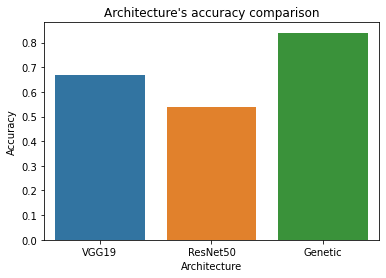

In [8]:
accuracy_list = [genetic_validation[1], vgg19_validation[1], ResNet50_validation[1]]

sns.barplot(x=["Best Individual", "VGG19", "ResNet50"], y=accuracy_list)
plt.title("Architecture accuracy comparison")
plt.xlabel("Architecture")
plt.ylabel("Accuracy")
plt.show()